# Speech Emotion Recognition

Import required libraries

In [ ]:
import os
import random
import sys
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)
import tensorflow
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
input_duration=3
# % pylab inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [ ]:
%cp -r '/content/drive/MyDrive/ravdess_data' /content/

In [ ]:
dir_list = os.listdir('/content/ravdess_data/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


Create DataFrame for Data

In [ ]:
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('/content/ravdess_data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = '/content/ravdess_data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [ ]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,/content/ravdess_data/Actor_01/03-01-01-01-01-...,1,1,male,0,0,1,1
1,/content/ravdess_data/Actor_01/03-01-03-01-02-...,1,1,male,0,1,0,3
2,/content/ravdess_data/Actor_01/03-01-07-02-01-...,1,1,male,1,0,0,7
3,/content/ravdess_data/Actor_01/03-01-08-02-01-...,1,1,male,1,0,0,8
4,/content/ravdess_data/Actor_01/03-01-07-01-02-...,1,1,male,0,1,0,7


Get the summary of the data

In [ ]:
data_df.describe(include='all')

,path,source,actor,gender,intensity,statement,repetition,emotion
count,1440,1440,1440,1440,1440,1440,1440,1440
unique,1440,1,24,2,2,2,2,8
top,/content/ravdess_data/Actor_01/03-01-01-01-01-...,1,1,male,0,0,1,3
freq,1,1440,60,720,768,720,720,192


Audio files waveform and spectrogram

In [ ]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

/content/ravdess_data/Actor_18/03-01-07-01-02-01-18.wav


(22050, array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.2378275e-07, -1.9007311e-07,  0.0000000e+00], dtype=float32))

In [ ]:
len(samples), sample_rate

(80931, 22050)

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
sample_rate/ len(samples)

0.2724543129332394

Plotting Wave Form and Spectrogram

Text(0.5, 0, 'Seconds')

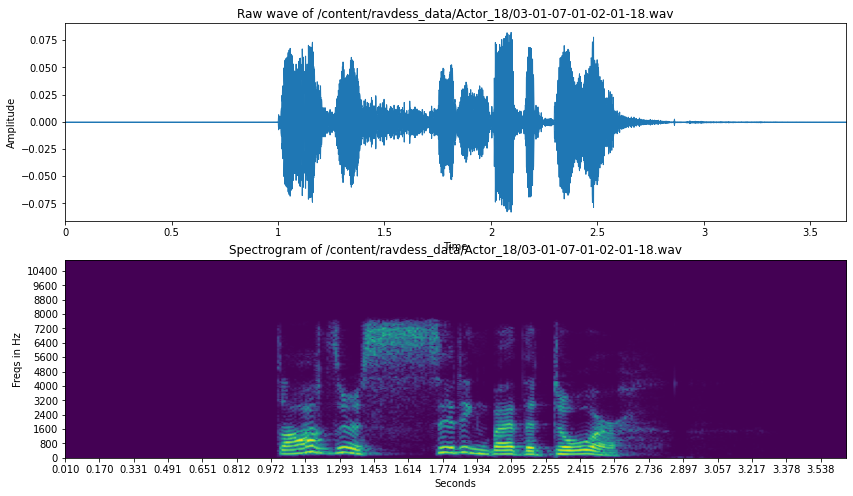

In [ ]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [ ]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 6.2476297e-06, -2.1842367e-05, -2.7487866e-05, ...,
        -4.7796234e-04, -1.0620864e-03, -1.0092730e-03], dtype=float32),
 array([21504, 60416]))

Plotting Mel Power Spectrogram

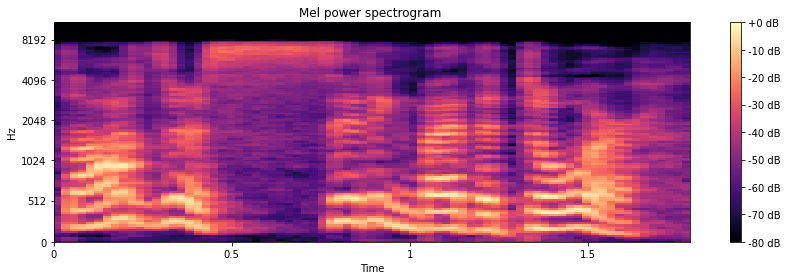

In [ ]:
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

Plotting MFCC features

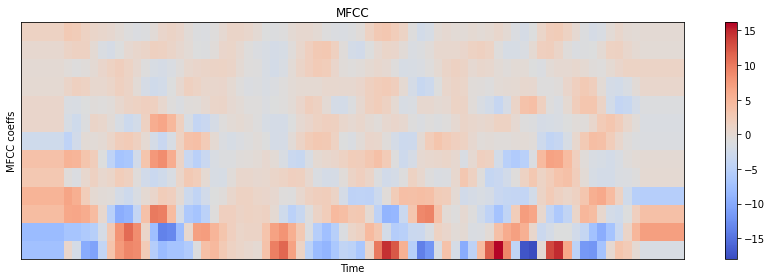

In [ ]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [ ]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [ ]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [ ]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [ ]:
# # 2 class: Positive & Negative

# # Positive: Calm, Happy
# # Negative: Angry, Fearful, Sad

# label2_list = []
# for i in range(len(data_df)):
#     if data_df.emotion[i] == 2: # Calm
#         lb = "_positive"
#     elif data_df.emotion[i] == 3: # Happy
#         lb = "_positive"
#     elif data_df.emotion[i] == 4: # Sad
#         lb = "_negative"
#     elif data_df.emotion[i] == 5: # Angry
#         lb = "_negative"
#     elif data_df.emotion[i] == 6: # Fearful
#         lb = "_negative"
#     else:
#         lb = "_none"
        
#     # Add gender to the label    
#     label2_list.append(data_df.gender[i] + lb)
    
# len(label2_list)

In [ ]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [ ]:
# # 5 class: angry, calm, sad, happy & fearful
# label5_list = []
# for i in range(len(data_df)):
#     if data_df.emotion[i] == 2:
#         lb = "_calm"
#     elif data_df.emotion[i] == 3:
#         lb = "_happy"
#     elif data_df.emotion[i] == 4:
#         lb = "_sad"
#     elif data_df.emotion[i] == 5:
#         lb = "_angry"
#     elif data_df.emotion[i] == 6:
#         lb = "_fearful"    
#     else:
#         lb = "_none"
    
#     # Add gender to the label  
#     label5_list.append(data_df.gender[i] + lb)
    
# len(label5_list)

In [ ]:
# # All class

# label8_list = []
# for i in range(len(data_df)):
#     if data_df.emotion[i] == 1:
#         lb = "_neutral"
#     elif data_df.emotion[i] == 2:
#         lb = "_calm"
#     elif data_df.emotion[i] == 3:
#         lb = "_happy"
#     elif data_df.emotion[i] == 4:
#         lb = "_sad"
#     elif data_df.emotion[i] == 5:
#         lb = "_angry"
#     elif data_df.emotion[i] == 6:
#         lb = "_fearful"
#     elif data_df.emotion[i] == 7:
#         lb = "_disgust"
#     elif data_df.emotion[i] == 8:
#         lb = "_surprised"
#     else:
#         lb = "_none"
        
#     # Add gender to the label 
#     label8_list.append(data_df.gender[i]  + lb)
    
# len(label8_list)

In [ ]:
# Select the label set you want by commenting the unwanteds.

# data_df['label'] = label2_list
data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/ravdess_data/Actor_01/03-01-01-01-01-...,1,1,male,0,0,1,1,male_neutral
1,/content/ravdess_data/Actor_01/03-01-03-01-02-...,1,1,male,0,1,0,3,male_positive
2,/content/ravdess_data/Actor_01/03-01-07-02-01-...,1,1,male,1,0,0,7,male_none
3,/content/ravdess_data/Actor_01/03-01-08-02-01-...,1,1,male,1,0,0,8,male_none
4,/content/ravdess_data/Actor_01/03-01-07-01-02-...,1,1,male,0,1,0,7,male_none


In [ ]:
print (data_df.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'male_none', 'female_none',
       'male_neutral', 'female_neutral', 'male_positive', 'female_positive'],
      dtype='object')


Plotting the emotion distribution

In [ ]:
def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

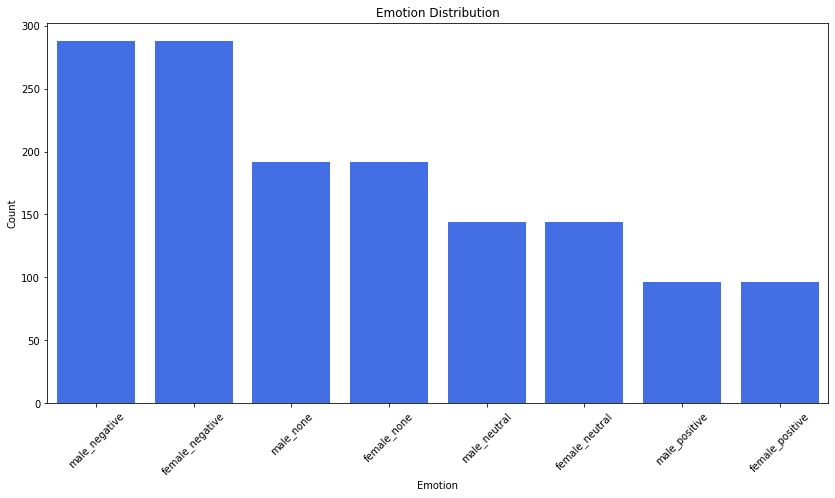

In [ ]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [ ]:
# Female Data Set

## Uncomment all below to use Female set 

# data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
# data2_df = data2_df[data2_df.label != "male_fearful"]
# data2_df = data2_df[data2_df.label != "male_calm"]
# data2_df = data2_df[data2_df.label != "male_positive"]
# data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [ ]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

440


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/ravdess_data/Actor_01/03-01-01-01-01-...,1,1,male,0,0,1,1,male_neutral
1,/content/ravdess_data/Actor_01/03-01-03-01-02-...,1,1,male,0,1,0,3,male_positive
2,/content/ravdess_data/Actor_01/03-01-06-01-02-...,1,1,male,0,1,0,6,male_negative
3,/content/ravdess_data/Actor_01/03-01-02-02-02-...,1,1,male,1,1,1,2,male_neutral
4,/content/ravdess_data/Actor_01/03-01-02-02-02-...,1,1,male,1,1,0,2,male_neutral


In [ ]:
print (len(data3_df))
data3_df.head()

88


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/ravdess_data/Actor_21/03-01-05-01-01-...,1,21,male,0,0,1,5,male_negative
1,/content/ravdess_data/Actor_21/03-01-05-01-01-...,1,21,male,0,0,0,5,male_negative
2,/content/ravdess_data/Actor_21/03-01-02-02-02-...,1,21,male,1,1,0,2,male_neutral
3,/content/ravdess_data/Actor_21/03-01-03-02-02-...,1,21,male,1,1,1,3,male_positive
4,/content/ravdess_data/Actor_21/03-01-05-02-01-...,1,21,male,1,0,0,5,male_negative


In [ ]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 440/440 [00:32<00:00, 13.57it/s]


In [ ]:
data.head()

,feature
0,"[-62.625893, -63.899044, -64.441826, -59.98270..."
1,"[-65.42778, -65.42778, -65.42778, -65.42778, -..."
2,"[-60.113277, -61.480373, -62.33713, -62.33713,..."
3,"[-70.74794, -70.74794, -70.74794, -70.74794, -..."
4,"[-73.25564, -73.25564, -73.25564, -73.25564, -..."


In [ ]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [ ]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-62.625893,-63.899044,-64.441826,-59.982704,-60.297195,-61.611835,-64.753067,-65.390709,-65.390709,-65.390709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-59.403160,...,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.42778,-65.427780,-65.42778,-65.427780,-65.427780
2,-60.113277,-61.480373,-62.337132,-62.337132,-62.337132,-62.099205,-62.337132,-62.337132,-62.337132,-62.337132,...,-32.547890,-33.296577,-36.691654,-36.410686,NaN,NaN,NaN,NaN,NaN,NaN
3,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,...,-69.244797,-70.747940,-70.747940,-70.747940,-70.747940,-70.74794,-70.747940,-70.74794,-70.030281,-69.237282
4,-73.255638,-73.255638,-73.255638,-73.255638,-73.180733,-73.255638,-73.255638,-73.255638,-73.255638,-73.255638,...,-50.391888,-50.809422,-55.574772,-54.543968,-53.226845,-56.15377,-57.413322,-58.65678,-59.735989,-57.997879


In [ ]:
newdf = pd.concat([df3,labels], axis=1)

In [ ]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

440

In [ ]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-62.625893,-63.899044,-64.441826,-59.982704,-60.297195,-61.611835,-64.753067,-65.390709,-65.390709,-65.390709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
1,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-59.403160,...,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,male_positive
2,-60.113277,-61.480373,-62.337132,-62.337132,-62.337132,-62.099205,-62.337132,-62.337132,-62.337132,-62.337132,...,-33.296577,-36.691654,-36.410686,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
3,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,...,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.030281,-69.237282,male_neutral
4,-73.255638,-73.255638,-73.255638,-73.255638,-73.180733,-73.255638,-73.255638,-73.255638,-73.255638,-73.255638,...,-50.809422,-55.574772,-54.543968,-53.226845,-56.153770,-57.413322,-58.656780,-59.735989,-57.997879,male_neutral
5,-37.560925,-40.180683,-41.410522,-42.368118,-42.186131,-42.514462,-42.175903,-40.354984,-38.986984,-39.012978,...,-45.183655,-45.599392,-44.978264,-44.341820,-44.514523,-43.967445,-44.792419,-45.679649,-45.719345,male_negative
6,-60.574200,-60.223934,-60.949566,-60.959072,-60.982517,-60.982449,-60.982449,-60.982449,-60.982449,-60.360420,...,-60.982449,-60.982449,-60.982449,-60.982449,-60.982449,-60.982449,NaN,NaN,NaN,male_positive
7,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,...,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,male_neutral
8,-40.801826,-40.789444,-40.809124,-40.879761,-40.623215,-40.421726,-40.696159,-40.963448,-41.012199,-40.830307,...,-26.794384,-29.444084,-28.914486,-29.604836,-32.086174,-33.720039,-32.316589,-31.793428,-32.554985,male_negative
9,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,...,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,-62.105949,male_negative


In [ ]:
rnewdf.isnull().sum().sum()

2832

In [ ]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-62.625893,-63.899044,-64.441826,-59.982704,-60.297195,-61.611835,-64.753067,-65.390709,-65.390709,-65.390709,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,male_neutral
1,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-59.403160,...,-65.427780,-65.427780,-65.427780,-65.427780,-65.42778,-65.427780,-65.42778,-65.427780,-65.427780,male_positive
2,-60.113277,-61.480373,-62.337132,-62.337132,-62.337132,-62.099205,-62.337132,-62.337132,-62.337132,-62.337132,...,-33.296577,-36.691654,-36.410686,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,male_negative
3,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,...,-70.747940,-70.747940,-70.747940,-70.747940,-70.74794,-70.747940,-70.74794,-70.030281,-69.237282,male_neutral
4,-73.255638,-73.255638,-73.255638,-73.255638,-73.180733,-73.255638,-73.255638,-73.255638,-73.255638,-73.255638,...,-50.809422,-55.574772,-54.543968,-53.226845,-56.15377,-57.413322,-58.65678,-59.735989,-57.997879,male_neutral


# Data Augmentation

In [ ]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

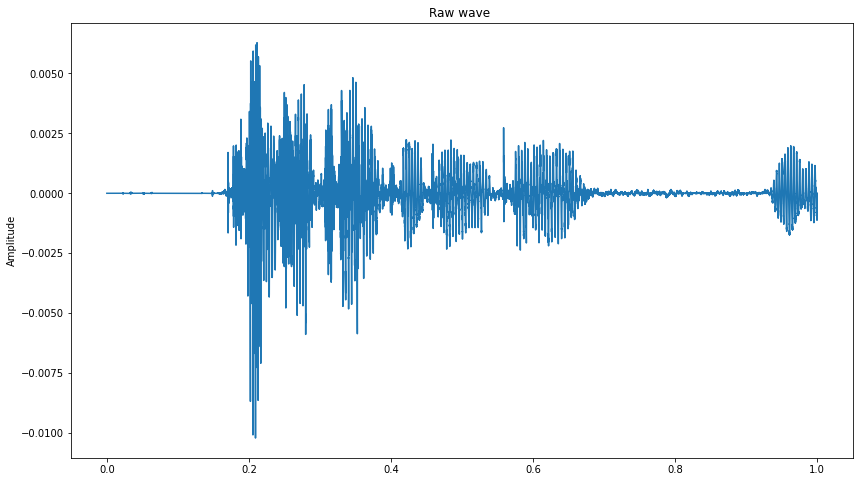

In [ ]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

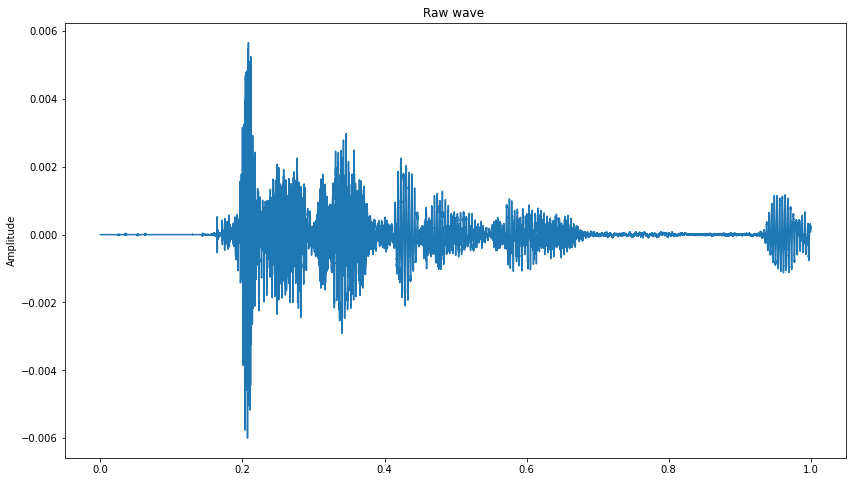

In [ ]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [ ]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 440/440 [00:39<00:00, 11.16it/s]


In [ ]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 440/440 [02:28<00:00,  2.97it/s]


In [ ]:
len(syn_data1), len(syn_data2) 

(440, 440)

In [ ]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [ ]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

440

In [ ]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-53.767182,-54.158280,-55.231337,-53.355720,-52.321619,-51.793723,-52.469022,-52.611633,-52.471853,-51.373577,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-51.665794,-52.421041,-53.514763,-53.471144,-51.858304,-51.983678,-51.932847,-50.923956,-51.270294,-52.489972,...,-51.772931,-52.149382,-54.205924,-54.955706,-53.547111,-53.500207,-54.886044,-57.555493,-56.294680,male_positive
2,-54.432817,-53.450165,-53.019111,-53.347936,-55.872068,-57.047275,-54.296152,-53.165145,-53.419774,-54.603433,...,-31.551504,-34.511539,-35.011564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_negative
3,-57.656367,-57.744759,-57.081026,-59.131639,-59.945668,-58.757427,-58.100032,-58.185059,-59.535006,-58.682420,...,-56.716181,-57.817293,-59.072344,-58.480881,-58.015284,-56.263440,-55.933242,-55.047493,-53.943538,male_neutral
4,-73.255584,-73.255584,-73.255584,-73.255584,-72.860227,-73.061965,-73.255584,-73.255584,-73.255584,-73.255584,...,-50.777123,-55.543954,-54.503966,-53.193560,-56.161083,-57.444475,-58.736090,-59.725267,-58.024694,male_neutral


In [ ]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

440

In [ ]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-63.595449,-65.325476,-65.239325,-63.471769,-63.768196,-65.700200,-67.647913,-68.460398,-68.460398,-68.460398,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-66.237088,-66.237088,-66.237088,-66.237088,-66.237088,-66.237088,-66.237088,-66.237088,-65.001367,-63.474862,...,-66.237088,-66.237088,-66.237088,-66.237088,-66.237088,-66.237088,-66.237088,-66.237088,-66.237088,male_positive
2,-61.593627,-63.611100,-65.675207,-65.675207,-65.675207,-65.590530,-65.675207,-65.675207,-65.675207,-65.675207,...,-38.066498,-36.641563,-38.853628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_negative
3,-73.059997,-73.059997,-73.059997,-72.367737,-73.059997,-73.059997,-73.059997,-73.059997,-73.059997,-73.059997,...,-71.901457,-73.059997,-73.059997,-73.059997,-73.059997,-73.059997,-73.059997,-73.054578,-73.052754,male_neutral
4,-74.651559,-74.651559,-74.651559,-74.651559,-74.651559,-74.254882,-74.651559,-74.651559,-74.651559,-74.651559,...,-53.197525,-56.221978,-57.759158,-55.851338,-58.090079,-58.973441,-61.021856,-63.696850,-63.763035,male_neutral


In [ ]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-62.625893,-63.899044,-64.441826,-59.982704,-60.297195,-61.611835,-64.753067,-65.390709,-65.390709,-65.390709,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,male_neutral
1,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-65.427780,-59.403160,...,-65.427780,-65.427780,-65.427780,-65.427780,-65.42778,-65.427780,-65.42778,-65.427780,-65.427780,male_positive
2,-60.113277,-61.480373,-62.337132,-62.337132,-62.337132,-62.099205,-62.337132,-62.337132,-62.337132,-62.337132,...,-33.296577,-36.691654,-36.410686,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,male_negative
3,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,-70.747940,...,-70.747940,-70.747940,-70.747940,-70.747940,-70.74794,-70.747940,-70.74794,-70.030281,-69.237282,male_neutral
4,-73.255638,-73.255638,-73.255638,-73.255638,-73.180733,-73.255638,-73.255638,-73.255638,-73.255638,-73.255638,...,-50.809422,-55.574772,-54.543968,-53.226845,-56.15377,-57.413322,-58.65678,-59.735989,-57.997879,male_neutral


In [ ]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
y_train.value_counts()

male_negative    576
male_neutral     288
male_positive    192
Name: label, dtype: int64

In [ ]:
y_test.value_counts()

male_negative    144
male_neutral      72
male_positive     48
Name: label, dtype: int64

In [ ]:
X_train.isna().sum().sum()

0

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
X_train.shape

(1056, 259)

# Model Training

## MLP model

In [ ]:
#Initialize the Multi Layer Perceptron Classifier
mlp_model = MLPClassifier(alpha=0.01, batch_size=64, epsilon=1e-08, hidden_layer_sizes=(900,), learning_rate='adaptive', max_iter=1000)

In [ ]:
#Train the model
mlp_model.fit(X_train, y_train)

MLPClassifier(alpha=0.01, batch_size=64, hidden_layer_sizes=(900,),
              learning_rate='adaptive', max_iter=1000)

## Predictions on test data

In [ ]:
#Predict for the test set
y_pred = mlp_model.predict(X_test)

In [ ]:
#Calculate the accuracy of our model
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 53.41%


## LSTM Model

In [ ]:
input_array= keras.Input(shape=(X_train.shape[1],1), name = 'input_array')
lstm_layer = LSTM(512, name = 'lstm_layer')(input_array)
dense_1 = Dense(256, activation= 'relu', kernel_initializer='he_normal', name= 'dense_1')(lstm_layer)
dropout_1 = Dropout(rate= 0.2,  name= 'dropout_1')(dense_1)
dense_2 = Dense(128, activation= 'relu', kernel_initializer='he_normal',  name= 'dense_2')(dropout_1)
bn= BatchNormalization()(dense_2)
output_layer = Dense(3, activation= 'softmax', name= 'output_layer')(bn)
model_lstm = Model(inputs=input_array, outputs= output_layer)

In [ ]:
model_lstm.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_array (InputLayer)    [(None, 259, 1)]          0         
                                                                 
 lstm_layer (LSTM)           (None, 512)               1052672   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                           

In [ ]:
model_lstm.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tensorflow.keras.metrics.Precision()])
history_lstm = model_lstm.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
66/66 [==============================] - 15s 126ms/step - loss: 1.2789 - precision_3: 0.3810 - val_loss: 1.2052 - val_precision_3: 0.1558
Epoch 2/100
66/66 [==============================] - 8s 114ms/step - loss: 1.1451 - precision_3: 0.4450 - val_loss: 1.3012 - val_precision_3: 0.1513
Epoch 3/100
66/66 [==============================] - 7s 113ms/step - loss: 1.1579 - precision_3: 0.4125 - val_loss: 1.1711 - val_precision_3: 0.2000
Epoch 4/100
66/66 [==============================] - 7s 113ms/step - loss: 1.1249 - precision_3: 0.4476 - val_loss: 1.1059 - val_precision_3: 0.4691
Epoch 5/100
66/66 [==============================] - 8s 114ms/step - loss: 1.0981 - precision_3: 0.4462 - val_loss: 1.1342 - val_precision_3: 0.4375
Epoch 6/100
66/66 [==============================] - 8s 114ms/step - loss: 1.0768 - precision_3: 0.5059 - val_loss: 1.0557 - val_precision_3: 0.5319
Epoch 7/100
66/66 [==============================] - 7s 113ms/step - loss: 1.0561 - precision_3: 0.5157 -

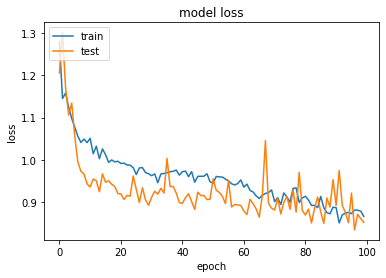

In [ ]:
# Plotting the Train Valid Loss Graph

plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model
model_lstm.save('model_lstm.h5')

## Predictions on LSTM model

In [ ]:
loaded_model = load_model('model_lstm.h5')

# evaluate loaded model on test data
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

precision_3: 64.95%


In [ ]:
len(data3_df)

88

In [ ]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 88/88 [00:06<00:00, 13.41it/s]


In [ ]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

6/6 [==============================] - 1s 52ms/step


In [ ]:
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_negative
1,male_negative
2,male_negative
3,male_negative
4,male_negative
5,male_negative
6,male_negative
7,male_negative
8,male_negative
9,male_neutral


In [ ]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_negative
1,male_negative
2,male_neutral
3,male_positive
4,male_negative
5,male_positive
6,male_negative
7,male_neutral
8,male_negative
9,male_negative


In [ ]:
finaldf = actualdf.join(preddf)

In [ ]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_negative,male_negative
21,male_positive,male_negative
22,male_positive,male_negative
23,male_neutral,male_negative
24,male_neutral,male_negative
25,male_negative,male_negative
26,male_negative,male_negative
27,male_positive,male_negative
28,male_negative,male_negative
29,male_neutral,male_neutral


In [ ]:
confusion_matrix(actual, preds1)

array([[38, 10,  0],
       [15,  9,  0],
       [16,  0,  0]])

## CNN Model

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
# Set up Keras util functions

from tensorflow.keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(3))
model.add(Activation('softmax'))
opt = tensorflow.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 259, 256)          2304      
                                                                 
 activation (Activation)     (None, 259, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 259, 256)          524544    
                                                                 
 batch_normalization_1 (Batc  (None, 259, 256)         1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 259, 256)          0         
                                                                 
 dropout (Dropout)           (None, 259, 256)          0         
                                                        

In [ ]:
# Compile your model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=500,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/500
66/66 [==============================] - 13s 37ms/step - loss: 1.0580 - accuracy: 0.5199 - fscore: 0.4342 - val_loss: 1.0834 - val_accuracy: 0.5417 - val_fscore: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/500
66/66 [==============================] - 2s 30ms/step - loss: 0.9543 - accuracy: 0.5634 - fscore: 0.4544 - val_loss: 1.0587 - val_accuracy: 0.5341 - val_fscore: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/500
66/66 [==============================] - 2s 34ms/step - loss: 0.9293 - accuracy: 0.5720 - fscore: 0.4829 - val_loss: 1.0396 - val_accuracy: 0.6061 - val_fscore: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/500
66/66 [==============================] - 3s 39ms/step - loss: 0.9199 - accuracy: 0.5710 - fscore: 0.4736 - val_loss: 0.9989 - val_accuracy: 0.5985 - val_fscore: 0.0069 - lr: 1.0000e-04
Epoch 5/500
66/66 [==============================] - 3s 39ms/step - loss: 0.9016 - accuracy: 0.5871 - fscore: 0.4904 - val_loss: 0.9670 - val_accuracy: 0.6098 - val_fscore: 0.1392 - lr: 1.0000e-04
Ep

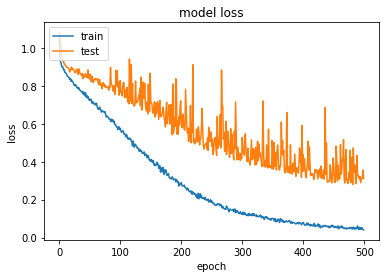

In [ ]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction on CNN model

In [ ]:
# Saving the model
model.save('model.h5')

In [ ]:
loaded_model = load_model('model.h5', custom_objects={"fscore": fscore})

# evaluate loaded model on test data
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 90.15%


In [ ]:
len(data3_df)

88

In [ ]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 88/88 [00:06<00:00, 13.38it/s]


In [ ]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

6/6 [==============================] - 0s 10ms/step


In [ ]:
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_positive
1,male_positive
2,male_neutral
3,male_positive
4,male_negative
5,male_neutral
6,male_positive
7,male_positive
8,male_negative
9,male_positive


In [ ]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_negative
1,male_negative
2,male_neutral
3,male_positive
4,male_negative
5,male_positive
6,male_negative
7,male_neutral
8,male_negative
9,male_negative


In [ ]:
finaldf = actualdf.join(preddf)

In [ ]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_negative,male_negative
21,male_positive,male_positive
22,male_positive,male_neutral
23,male_neutral,male_positive
24,male_neutral,male_negative
25,male_negative,male_negative
26,male_negative,male_negative
27,male_positive,male_positive
28,male_negative,male_negative
29,male_neutral,male_neutral


In [ ]:
confusion_matrix(actual, preds1)

array([[30,  5, 13],
       [ 3, 12,  9],
       [ 8,  2,  6]])